# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [205]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# set a random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [206]:
# load datasets
train_csv = pd.read_csv('data_sentiment/train.csv',header=None)
dev_csv = pd.read_csv('data_sentiment/dev.csv',header=None)
test_csv = pd.read_csv('data_sentiment/test.csv',header=None)

If you use Pandas you can see a sample of the data.

In [207]:
train_csv.head()

,0,1
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [208]:
# transform into Python lists
train_list=train_csv[0].tolist()
dev_list=dev_csv[0].tolist()
test_list=test_csv[0].tolist()
# transform into NumPy arrays
Y_tr = np.array(train_csv[1])
Y_dev = np.array(dev_csv[1])
Y_test = np.array(test_csv[1])

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [209]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [210]:
import re
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    # use regular expression to fina all tokens
    wordRE = re.compile(token_pattern)
    raw_list = wordRE.findall(str(x_raw))
    # remove stop words
    dealed_list = []
    for word in raw_list:
        if word.lower() not in stop_words:
            dealed_list.append(word.lower())
    x = []
    # a function used for extracting grams 
    def getCurGrams(dealed_list, n):
        output = []
        if n == 3:
            for i in range(0, len(dealed_list)-2):
                output.append((dealed_list[i],dealed_list[i+1],dealed_list[i+2]))
        elif n == 2:
            for i in range(0, len(dealed_list)-1):
                output.append((dealed_list[i],dealed_list[i+1]))
        else:
            for i in range(0, len(dealed_list)):
                output.append(dealed_list[i])
        return output
    # extract all grams
    for gram in range(ngram_range[0],ngram_range[1]+1):
        x += getCurGrams(dealed_list, gram)
    # remove grams which are not in the vocab
    if vocab:
        remove_x = []
        for ele in x:
            if ele not in list(vocab):
                remove_x.append(ele)
        for ele in remove_x:
            x.remove(ele)
    return x
                                  

In [211]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [212]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [213]:
from collections import Counter
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    vocab_raw_df = [] # a list used to store all the grams, each text's grams are unique
    whole_corpus = [] # a list used to store the whole corpus's grams
    for doc in X_raw:
        # cur_str is the whole raw string of a text
        cur_str = ''
        cur_str_whole = ''
        for line in doc:
            cur_str += str(line)
            cur_str_whole += str(line)
        # To get all the ngrams, we can use set() to make sure that every text has no same ngram 
        # and it is the basis of counting the document frequency with "Counter"
        vocab_raw_df += list(set(extract_ngrams(cur_str, ngram_range, stop_words=stop_words)))
        whole_corpus += extract_ngrams(cur_str, ngram_range, stop_words=stop_words)
        
    # define a Counter
    df = Counter(vocab_raw_df)
    if keep_topN and keep_topN > 0:
        vocab_counts = df.most_common(keep_topN)
    else:
        vocab_counts = df.most_common()
    # filter to get those grams whose counts are greater than min_df
    if (min_df and min_df > 1):
        vocab_counts = list(filter(lambda x:x[1] >= min_df, vocab_counts))

    vocab = set(dict(vocab_counts).keys())
    # initiate the ngram_counts with 0
    ngram_counts = dict.fromkeys(vocab,0)
    for doc in whole_corpus:
        for ngram in doc:
            if ngram in vocab:
                # count each gram in whole corpus
                ngram_counts[ngram] += 1
    
    return (vocab, df, ngram_counts)

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [214]:
vocab, df, ngram_counts = get_vocab(train_list, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['emotion', 'score', 'prominent', ('film', 'festival'), 'reeves', ('action', 'sequences'), 'cusack', 'between', 'becomes', ('him', 'but'), 'hands', ('back', 'into'), 'wilson', 'title', 'russell', 'dating', 'size', 'spirited', 'upper', ('so', 'well'), 'impact', ('so', 'when'), 'then', 'featuring', 'traditional', ('lot', 'more'), 'trash', 'blood', ('bottom', 'line'), 'pair', 'serves', 'showed', 'stale', 'noticeable', 'bacon', 'occurs', ('whole', 'thing'), ('other', 'words'), 'gang', 'effect', 'portrays', 'month', 'obviously', ('movie', 'but'), 'office', 'fails', 'victim', 'explains', 'cinematic', 'roots', 'among', 'exceptions', 'common', 'awkward', 'bed', 'equivalent', 'gem', ('blair', 'witch'), 'overcome', 'credits', ('know', 'but'), 'glory', ('film', 'too'), 'many', 'nuclear', 'creative', 'davis', 'but', ('film', 'actually'), ('based', 'novel'), 'lots', 'if', 'brilliantly', ('tells', 'him'), 'create', ('something', 'about'), ('doesn', 'know'), 'hiding', 'return', 'jerry', ('feel'

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [215]:
vocab_dict = {}
for i, gram in enumerate(vocab):
    vocab_dict[gram] = i

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [217]:
# extract n-grams
train_gram = []
for doc in train_list:
    cur_str = ''
    for line in doc:
        cur_str += str(line)
    train_gram.append(extract_ngrams(cur_str, ngram_range=(1,3), stop_words=stop_words))
    
dev_gram = []
for doc in dev_list:
    cur_str = ''
    for line in doc:
        cur_str += str(line)
    dev_gram.append(extract_ngrams(cur_str, ngram_range=(1,3), stop_words=stop_words))
    
test_gram = []
for doc in test_list:
    cur_str = ''
    for line in doc:
        cur_str += str(line)
    test_gram.append(extract_ngrams(cur_str, ngram_range=(1,3), stop_words=stop_words))

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [218]:
def vectorise(X_ngram, vocab):
    # initiate X_vec
    X_vec = [[0 for j in range(len(vocab))] for i in range(len(X_ngram))]
    for i, doc in enumerate(X_ngram):
        for gram in doc:
            if gram in vocab_dict:
                cur_index = vocab_dict[gram]
                X_vec[i][cur_index] += 1 # count corresponding ngrams

    X_vec = np.array(X_vec)
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [219]:
# get document vectors in the train set
X_tr_count = vectorise(train_gram, vocab)

In [220]:
X_tr_count.shape

(1400, 5000)

In [221]:
X_tr_count[:2,:50]

array([[0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

In [222]:
# get document vectors in the development and test set
X_dev_count = vectorise(dev_gram, vocab)
X_test_count = vectorise(test_gram, vocab)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [223]:
# get the idfs of train set
import math
cur_ngram_df = df.most_common(5000)
ngram_df = [0 for i in range(len(vocab))]
# keep ngram_df's order in the same sequence with vocab
for gram in cur_ngram_df:
    cur_index = vocab_dict[gram[0]]
    ngram_df[cur_index] = gram
    
D = len(train_list) # the size of total documents
idfs = [math.log10(D / x[1]) for x in ngram_df]
idfs = np.array(idfs)

Then transform your count vectors to tf.idf vectors:

In [227]:
X_tr_tfidf = [[tf*idfs[i] for (i, tf) in enumerate(doc)] for doc in X_tr_count]
X_tr_tfidf = np.array(X_tr_tfidf)

In [228]:
X_tr_tfidf[1,:50]

array([0.        , 1.03218468, 0.        , 1.73115469, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.43467024, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [229]:
# get the tfidfs of development set
X_dev_tfidf = [[tf*idfs[i] for (i, tf) in enumerate(doc)] for doc in X_dev_count]
X_dev_tfidf = np.array(X_dev_tfidf)

In [230]:
# get the tfidfs of test set
X_test_tfidf = [[tf*idfs[i] for (i, tf) in enumerate(doc)] for doc in X_test_count]
X_test_tfidf = np.array(X_test_tfidf)

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [231]:
def sigmoid(z):
    
    z = 1 / (1 + np.exp(-z))
    
    return z

In [232]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [233]:
def predict_proba(X, weights):
    # z is the mastrix product of X and weights
    Z = np.dot(X, weights.T)
    preds_proba = sigmoid(Z)
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [234]:
def predict_class(X, weights):
    
    # get the prediction probabilities
    predict_data = predict_proba(X, weights)
    # get the corresponding class
    preds_class = []
    for x in predict_data:
        if x < 0.5:
            preds_class.append(0)
        else:
            preds_class.append(1)
    preds_class = np.array(preds_class)
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [235]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    H = predict_proba(X, weights)
    m = Y.shape[0]
    # get the loss value
    L = -np.dot(Y,np.log(H))-np.dot((1-Y),np.log(1-H))
    weights_l2 = np.array([x*x for x in weights])
    # add model weights
    l = L/m + alpha*np.sum(weights_l2)

    return l

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [236]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    # initiate the weights
    W = np.zeros(X_tr.shape[1])
    # get the loss of development set at the beginning
    loss_dev = binary_loss(X_dev, Y_dev, W, alpha)
    for e in range(epochs):
        random.seed(123)
        np.random.seed(123)
        # shuffle X_tr and corresponding Y_tr
        shuffle_indices = np.random.permutation(np.arange(len(X_tr))) 
        X_tr = X_tr[shuffle_indices]
        Y_tr = Y_tr[shuffle_indices]
        # update weights
        for i,x in enumerate(X_tr):
            h = predict_proba(x, W)
            dW = np.dot(x.T, (h-Y_tr[i])) + 2*alpha*W
            W -= lr*dW
        loss_tr = binary_loss(X_tr, Y_tr, W, alpha)
        training_loss_history.append(loss_tr)
        loss_cur = binary_loss(X_dev, Y_dev, W, alpha)
        validation_loss_history.append(loss_cur)
        if print_progress:
            print('Epoch: %d| Training loss: %f | Validation loss: %f'%(e,loss_tr,loss_cur))
        if loss_dev - loss_cur < tolerance:
            print('diff',loss_dev - loss_cur)
            break
        loss_dev = loss_cur
    
    weights = W
    training_loss_history = np.array(training_loss_history)
    validation_loss_history = np.array(validation_loss_history)

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [311]:
w_count, training_loss_history, validation_loss_history = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.00005, 
                                             alpha=0.0001, 
                                             epochs=150)

Epoch: 0| Training loss: 0.657963 | Validation loss: 0.666680
Epoch: 1| Training loss: 0.630432 | Validation loss: 0.647845
Epoch: 2| Training loss: 0.606810 | Validation loss: 0.629664
Epoch: 3| Training loss: 0.586916 | Validation loss: 0.617004
Epoch: 4| Training loss: 0.569191 | Validation loss: 0.604093
Epoch: 5| Training loss: 0.553692 | Validation loss: 0.593436
Epoch: 6| Training loss: 0.539760 | Validation loss: 0.583908
Epoch: 7| Training loss: 0.527113 | Validation loss: 0.576027
Epoch: 8| Training loss: 0.515592 | Validation loss: 0.567965
Epoch: 9| Training loss: 0.504881 | Validation loss: 0.561219
Epoch: 10| Training loss: 0.495015 | Validation loss: 0.554929
Epoch: 11| Training loss: 0.485921 | Validation loss: 0.548560
Epoch: 12| Training loss: 0.477249 | Validation loss: 0.543251
Epoch: 13| Training loss: 0.469325 | Validation loss: 0.537842
Epoch: 14| Training loss: 0.461972 | Validation loss: 0.532907
Epoch: 15| Training loss: 0.454441 | Validation loss: 0.528852
Ep

Epoch: 131| Training loss: 0.209231 | Validation loss: 0.400682
Epoch: 132| Training loss: 0.208417 | Validation loss: 0.400417
Epoch: 133| Training loss: 0.207598 | Validation loss: 0.400090
Epoch: 134| Training loss: 0.206794 | Validation loss: 0.399771
Epoch: 135| Training loss: 0.206011 | Validation loss: 0.399608
Epoch: 136| Training loss: 0.205214 | Validation loss: 0.399249
Epoch: 137| Training loss: 0.204436 | Validation loss: 0.399042
Epoch: 138| Training loss: 0.203666 | Validation loss: 0.398699
Epoch: 139| Training loss: 0.202895 | Validation loss: 0.398488
Epoch: 140| Training loss: 0.202136 | Validation loss: 0.398240
Epoch: 141| Training loss: 0.201403 | Validation loss: 0.398174
diff 6.61914056235835e-05


Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

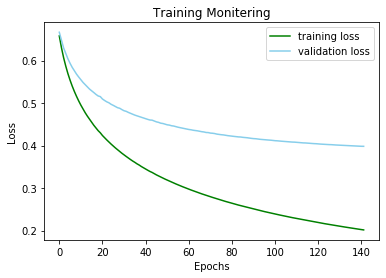

In [312]:
import matplotlib.pyplot as plt
cur_size = training_loss_history.shape[0]
x_axix = np.linspace(0,cur_size-1,num = cur_size)
plt.title('Training Monitering')
plt.plot(x_axix, training_loss_history, color='green', label='training loss')
plt.plot(x_axix, validation_loss_history, color='skyblue', label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Explain here...

It may be overfitting. Because the difference between validation loss and training loss tends to amplify and the validation loss is be prone to be stable while the training loss is still dropping slowly.

Compute accuracy, precision, recall and F1-scores:

In [239]:
def accuracy_score(Y_te,preds_te_count):
    # get the prediction classes
    Y_predict = predict_class(preds_te_count, w_count)
    # calculate the number of predictions are right
    result_arr = Y_te == Y_predict
    right_num = sum(result_arr==True)
    accuracy_score = right_num/Y_te.shape[0]
    return accuracy_score

def precision_score(Y_te,preds_te_count):
    Y_predict = predict_class(preds_te_count, w_count)
    # calculate the number of positive predictions in right predictions
    TruePositive = Y_te[Y_te == Y_predict] == 1
    # calculate the number of positive predictions in false predictions
    FalsePositive = Y_te[Y_te != Y_predict] == 1
    TP_num = sum(TruePositive==True)
    FP_num = sum(FalsePositive==True)
    precision_score = TP_num/(TP_num+FP_num)
    return precision_score

def recall_score(Y_te,preds_te_count):
    Y_predict = predict_class(preds_te_count, w_count)
    # calculate the number of positive predictions in right predictions
    TruePositive = Y_te[Y_te == Y_predict] == 1
    # calculate the number of negative predictions in false predictions
    FalseNegative = Y_te[Y_te != Y_predict] == 0
    TP_num = sum(TruePositive==True)
    FN_num = sum(FalseNegative==True)
    recall_score = TP_num/(TP_num+FN_num)
    return recall_score

def f1_score(Y_te,preds_te_count):
    PS = precision_score(Y_te,preds_te_count)
    CS = recall_score(Y_te,preds_te_count)
    f1_score = 2*PS*CS/(PS+CS)
    return f1_score

print('Accuracy:', accuracy_score(Y_test,X_test_count))
print('Precision:', precision_score(Y_test,X_test_count))
print('Recall:', recall_score(Y_test,X_test_count))
print('F1-Score:', f1_score(Y_test,X_test_count))

Accuracy: 0.8325
Precision: 0.85
Recall: 0.821256038647343
F1-Score: 0.8353808353808354


Finally, print the top-10 words for the negative and positive class respectively.

In [240]:
Z_w = zip(w_count,vocab)
# sort Z_w from high to low
Z_w_sorted = sorted(Z_w,key=lambda x: x[0],reverse=True)
w_new,vocab_new = zip(*Z_w_sorted)

# so the top 10 words for the positive are below:
positive_top_10 = vocab_new[:10]
print('top 10 words for the positive:\n',positive_top_10)


top 10 words for the positive:
 ('great', 'well', 'also', 'seen', 'fun', 'life', 'many', 'world', 'movies', 'both')


In [241]:
# so the top 10 words for the negative are below:
negative_top_10 = vocab_new[-10:]
print('top 10 words for the negative:\n',negative_top_10)

top 10 words for the negative:
 ('nothing', 'any', 'boring', 'plot', 'why', 'script', 'worst', 'unfortunately', 'only', 'bad')


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

Some of the classifier's features would generalise well while some are bad in a different domain. I will pick up 'great', 'fun', 'well', 'boring', 'worst', 'unfortunately', 'bad' etc. as important in the new domain.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [313]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.001, 
                         alpha=0.0001, 
                         epochs=200)

Epoch: 0| Training loss: 0.429285 | Validation loss: 0.546449
Epoch: 1| Training loss: 0.332395 | Validation loss: 0.494286
Epoch: 2| Training loss: 0.275775 | Validation loss: 0.462961
Epoch: 3| Training loss: 0.237538 | Validation loss: 0.442716
Epoch: 4| Training loss: 0.209505 | Validation loss: 0.428144
Epoch: 5| Training loss: 0.187724 | Validation loss: 0.417131
Epoch: 6| Training loss: 0.170417 | Validation loss: 0.408762
Epoch: 7| Training loss: 0.156060 | Validation loss: 0.401682
Epoch: 8| Training loss: 0.144170 | Validation loss: 0.396299
Epoch: 9| Training loss: 0.133919 | Validation loss: 0.391731
Epoch: 10| Training loss: 0.125104 | Validation loss: 0.388081
Epoch: 11| Training loss: 0.117399 | Validation loss: 0.385471
Epoch: 12| Training loss: 0.110663 | Validation loss: 0.382968
Epoch: 13| Training loss: 0.104643 | Validation loss: 0.380753
Epoch: 14| Training loss: 0.099251 | Validation loss: 0.378837
Epoch: 15| Training loss: 0.094440 | Validation loss: 0.377395
Ep

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

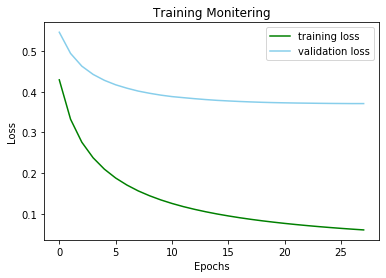

In [315]:
cur_size_tfidf = trl.shape[0]
x_ax_tfidf = np.linspace(0,cur_size_tfidf-1,num = cur_size_tfidf)
plt.title('Training Monitering')
plt.plot(x_ax_tfidf, trl, color='green', label='training loss')
plt.plot(x_ax_tfidf, devl, color='skyblue', label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

It may be overfitting. Because the final difference between validation loss and training loss is large and the validation loss is prone to be stable while the training loss is still dropping slowly.

Compute accuracy, precision, recall and F1-scores:

In [316]:
print('Accuracy:', accuracy_score(Y_test,X_test_tfidf))
print('Precision:', precision_score(Y_test,X_test_tfidf))
print('Recall:', recall_score(Y_test,X_test_tfidf))
print('F1-Score:', f1_score(Y_test,X_test_tfidf))

Accuracy: 0.835
Precision: 0.93
Recall: 0.7815126050420168
F1-Score: 0.8493150684931506


Print top-10 most positive and negative words:

In [317]:
Z_w_tfidf = zip(w_tfidf,vocab)
Z_w_tfidf_sorted = sorted(Z_w_tfidf,key=lambda x: x[0],reverse=True)
w_new_tfidf,vocab_new_tfidf = zip(*Z_w_tfidf_sorted)

# so the top 10 words for the positive are below:
positive_top_tfidf_10 = vocab_new_tfidf[:10]
print('top 10 words for the positive:\n',positive_top_tfidf_10)

top 10 words for the positive:
 ('great', 'hilarious', 'fun', 'perfectly', 'overall', 'terrific', 'definitely', 'life', 'seen', 'simple')


In [319]:
# so the top 10 words for the negative are below:
negative_top_tfidf_10 = vocab_new_tfidf[-10:]
print('top 10 words for the negative:\n',negative_top_tfidf_10)

top 10 words for the negative:
 ('nothing', 'script', 'poor', 'awful', 'waste', 'unfortunately', 'supposed', 'boring', 'worst', 'bad')


According to the top 10 words in the tfidf mode. Some of the classifier's features would generalise well while some are bad in a different domain. I will pick up 'great', 'fun', 'perfectly', 'terrific', 'boring', 'awful', 'unfortunately', 'bad' etc. as important in the new domain.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

I choose the right value of learning rate and regularisation strength to make the train loss and validation loss prone to be right at the stable status and make the losses as small as possible or the F1-score as high as possible and prevent the overfitting phenomenon. When the learning rate is greater, the epochs are less. The regularisation strength can accelerate the training process but may make the final losses not reach to a stable status.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.850|0.821|0.835|
| BOW-tfidf  |0.930|0.781|0.849|


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [247]:
random.seed(123)
np.random.seed(123)

# load data
data_tr = pd.read_csv('data_topic/train.csv',header=None)
data_dev = pd.read_csv('data_topic/dev.csv',header=None)
data_test = pd.read_csv('data_topic/test.csv',header=None)

In [248]:
data_tr.head()

,0,1
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [249]:
# transform into Python lists
train_topic_list=data_tr[1].tolist()
dev_topic_list=data_dev[1].tolist()
test_topic_list=data_test[1].tolist()
# transform labels into NumPy arrays
Y_topic_tr = np.array(data_tr[0])
Y_topic_dev = np.array(data_dev[0])
Y_topic_test = np.array(data_test[0])

In [250]:
vocab_topic, df_topic, ngram_counts_topic = get_vocab(train_topic_list, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab_topic))
print()
print(list(vocab_topic)[:100])
print()
print(df_topic.most_common()[:10])

5000

['score', 'slam', 'relations', 'prominent', 'between', ('three', 'years'), 'walker', 'becomes', 'www', 'custody', 'amat', ('set', 'start'), 'berlusconi', ('week', 'during', 'depth'), 'hands', ('back', 'into'), 'disappeared', ('jose', 'calif'), ('hunger', 'strike'), 'title', 'size', ('south', 'africa'), 'impact', 'stocks', 'then', 'managing', ('presidential', 'candidate'), 'showed', 'opec', 'amid', 'investors', ('meter', 'freestyle', 'relay'), ('reversed', 'government', 'said'), 'ohalete', 'month', ('company', 'wall'), 'region', 'office', 'strategy', ('san', 'diego'), ('wednesday', 'splashing', 'cold'), 'among', ('holy', 'city'), 'web', ('gold', 'united'), 'greece', 'midday', 'seattle', ('fleet', 'bank'), ('mart', 'lowe'), 'many', 'nuclear', 'democracy', ('fell', 'more', 'than'), ('season', 'after', 'undergoing'), 'but', ('white', 'sox', 'manager'), ('team', 'lost'), 'if', ('world', 'number'), ('third', 'quarter'), ('reuters', 'deere'), ('freestyle', 'relay'), ('conspiracy', 'murd

In [251]:
# create word dictionaries for reference
vocab_dict_topic = {}
for i, gram in enumerate(vocab_topic):
    vocab_dict_topic[gram] = i

In [252]:
# extract n-grams for each text in the training, validation and test sets
train_gram_topic = []
for doc in train_topic_list:
    cur_str = ''
    for line in doc:
        cur_str += str(line)
    train_gram_topic.append(extract_ngrams(cur_str, ngram_range=(1,3), stop_words=stop_words))
    
dev_gram_topic = []
for doc in dev_topic_list:
    cur_str = ''
    for line in doc:
        cur_str += str(line)
    dev_gram_topic.append(extract_ngrams(cur_str, ngram_range=(1,3), stop_words=stop_words))
    
test_gram_topic = []
for doc in test_topic_list:
    cur_str = ''
    for line in doc:
        cur_str += str(line)
    test_gram_topic.append(extract_ngrams(cur_str, ngram_range=(1,3), stop_words=stop_words))

In [253]:
def vectorise_topic(X_ngram, vocab_topic):
    X_vec = [[0 for j in range(len(vocab_topic))] for i in range(len(X_ngram))]
    for i, doc in enumerate(X_ngram):
        for gram in doc:
            if gram in vocab_dict_topic:
                cur_index = vocab_dict_topic[gram]
                X_vec[i][cur_index] += 1
    
    return np.array(X_vec)

In [262]:
# vectorise train, development and test set with tf
X_tr_count_topic = vectorise_topic(train_gram_topic, vocab_topic)
X_dev_count_topic = vectorise_topic(dev_gram_topic, vocab_topic)
X_test_count_topic = vectorise_topic(test_gram_topic, vocab_topic)

In [263]:
# calculate idf
cur_ngram_df_topic = df_topic.most_common(5000)
ngram_df_topic = [0 for i in range(len(vocab_topic))]
# keep ngram_df_topic's order in the same sequence with vocab_topic
for gram in cur_ngram_df_topic:
    cur_index = vocab_dict_topic[gram[0]]
    ngram_df_topic[cur_index] = gram
D_topic = len(train_topic_list)
idfs_topic = [math.log10(D_topic / x[1]) for x in ngram_df_topic]
idfs_topic = np.array(idfs_topic)

In [265]:
# vectorise train set with tfidf
X_tr_topic_tfidf = [[tf*idfs_topic[i] for (i, tf) in enumerate(doc)] for doc in X_tr_count_topic]
X_tr_topic_tfidf = np.array(X_tr_topic_tfidf)

In [266]:
# vectorise devlopment and test set with tfidf
X_dev_topic_tfidf = [[tf*idfs_topic[i] for (i, tf) in enumerate(doc)] for doc in X_dev_count_topic]
X_dev_topic_tfidf = np.array(X_dev_topic_tfidf)

X_test_topic_tfidf = [[tf*idfs_topic[i] for (i, tf) in enumerate(doc)] for doc in X_test_count_topic]
X_test_topic_tfidf = np.array(X_test_topic_tfidf)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [267]:
def softmax(z):
    # sum up a;; the exp(z) in the first dimension
    smax = np.exp(z)/np.sum(np.exp(z),axis=0)
    smax = smax.T
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [268]:
def predict_proba2(X, weights):
    # z is the mastrix product of X and weights
    Z = np.dot(weights, X.T)
    preds_proba = softmax(Z)
    
    return preds_proba

In [269]:
def predict_class2(X, weights):
    
    cur_prob = predict_proba(X, weights)
    # store each index of the greatest value
    preds_class = np.argmax(cur_prob, axis=1)
    preds_class = np.array([x+1 for x in preds_class])
    
    return preds_class

Toy example and expected functionality of the functions above:

In [270]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [271]:
predict_proba2(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [272]:
predict_class2(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [273]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    # get the prediction possibilities
    H = predict_proba2(X, weights)
    m = Y.shape[0]
    # calculate the loss
    L = np.sum(-Y*np.log(H))/m
    weights_new = np.array([x*x for x in weights])
    # add weights
    l = L + alpha*np.sum(weights_new)
    return l

Finally you need to modify SGD to support the categorical cross entropy loss:

In [274]:
# transform original vector in triple-dimension form data
def transform_data(origin_y, num_classes):
    
    new_y = np.zeros([origin_y.shape[0], num_classes])
    for i in range(origin_y.shape[0]):
        new_y[i][origin_y[i]-1] = 1

    return new_y

In [278]:
def SGD2(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    # initiate weights
    W = np.zeros((num_classes,X_tr.shape[1]))
    # transform development vector
    Y_dev = transform_data(Y_dev, num_classes)
    loss_dev = categorical_loss(X_dev, Y_dev, W, num_classes, alpha)
    # transform train vector
    Y_tr = transform_data(Y_tr, num_classes)
        
    for e in range(epochs):
        # shuffle data
        random.seed(123)
        np.random.seed(123)
        shuffle_indices = np.random.permutation(np.arange(len(X_tr))) 
        X_tr = X_tr[shuffle_indices]
        Y_tr = Y_tr[shuffle_indices]
        # update weights after each iteration
        for i,x in enumerate(X_tr):
            cur_x = np.array([x])
            h = predict_proba2(cur_x, W)
            dW = np.dot(cur_x.T, (h-Y_tr[i])).T + 2*alpha*W
            W -= lr*dW
        loss_tr = categorical_loss(X_tr, Y_tr, W, num_classes, alpha)
        training_loss_history.append(loss_tr)
        loss_cur = categorical_loss(X_dev, Y_dev, W, num_classes, alpha)
        validation_loss_history.append(loss_cur)
        if print_progress:
            print('Epoch: %d| Training loss: %f | Validation loss: %f'%(e,loss_tr,loss_cur))
        if loss_dev - loss_cur < tolerance:
            print('diff',loss_dev - loss_cur)
            break
        loss_dev = loss_cur
    
    weights = W
    training_loss_history = np.array(training_loss_history)
    validation_loss_history = np.array(validation_loss_history)

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [286]:
w_count_topic, loss_tr_count, dev_loss_count = SGD2(X_tr_count_topic, Y_topic_tr, 
                                             X_dev=X_dev_count_topic, 
                                             Y_dev=Y_topic_dev,
                                             num_classes=3,
                                             lr=0.003, 
                                             alpha=0.0001, 
                                             epochs=200)

Epoch: 0| Training loss: 0.704145 | Validation loss: 0.831907
Epoch: 1| Training loss: 0.569983 | Validation loss: 0.711250
Epoch: 2| Training loss: 0.495055 | Validation loss: 0.640205
Epoch: 3| Training loss: 0.444826 | Validation loss: 0.592580
Epoch: 4| Training loss: 0.407888 | Validation loss: 0.557566
Epoch: 5| Training loss: 0.379160 | Validation loss: 0.530494
Epoch: 6| Training loss: 0.355818 | Validation loss: 0.509419
Epoch: 7| Training loss: 0.336370 | Validation loss: 0.491814
Epoch: 8| Training loss: 0.319848 | Validation loss: 0.477267
Epoch: 9| Training loss: 0.305552 | Validation loss: 0.464831
Epoch: 10| Training loss: 0.293042 | Validation loss: 0.453765
Epoch: 11| Training loss: 0.281923 | Validation loss: 0.444349
Epoch: 12| Training loss: 0.271995 | Validation loss: 0.435863
Epoch: 13| Training loss: 0.263046 | Validation loss: 0.428559
Epoch: 14| Training loss: 0.254925 | Validation loss: 0.421821
Epoch: 15| Training loss: 0.247511 | Validation loss: 0.415894
Ep

Plot training and validation process and explain if your model overfit, underfit or is about right:

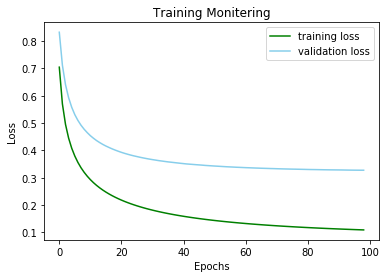

In [287]:
cur_size_topic = loss_tr_count.shape[0]
x_topic = np.linspace(0,cur_size_topic-1,num = cur_size_topic)
plt.title('Training Monitering')
plt.plot(x_topic, loss_tr_count, color='green', label='training loss')
plt.plot(x_topic, dev_loss_count, color='skyblue', label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

It may be about right. Because both the validation loss and training loss tends to be stable, their losses are both relatively small and their losses doen't differ a lot.

Compute accuracy, precision, recall and F1-scores:

In [288]:
def accuracy_score2(Y_te,preds_te_count):
    Y_predict = predict_class2(preds_te_count, w_count_topic)
    # get all the right predictions
    result_arr = Y_te == Y_predict
    right_num = sum(result_arr==True)
    accuracy_score = right_num/Y_te.shape[0]
    return accuracy_score

def precision_score2(Y_te,preds_te_count):
    Y_predict = predict_class2(preds_te_count, w_count_topic)
    ps = 0
    # get precision score for each class and sum up them
    for i in range(3):
        P = Y_te[Y_te == Y_predict] == i+1
        total = Y_predict == i+1
        P_num = sum(P==True)
        total_num = sum(total==True)
        ps += P_num/total_num
    # get average precision score
    precision_score = ps/3
    return precision_score

def recall_score2(Y_te,preds_te_count):
    Y_predict = predict_class2(preds_te_count, w_count_topic)
    rs = 0
    # get recall value for each class and sum up them
    for i in range(3):
        P = Y_te[Y_te == Y_predict] == i+1
        total = Y_te == i+1
        P_num = sum(P==True)
        total_num = sum(total==True)
        rs += P_num/total_num
    # get average recall score
    recall_score = rs/3
    return recall_score

def f1_score2(Y_te,preds_te_count):
    PS = precision_score2(Y_te,preds_te_count)
    CS = recall_score2(Y_te,preds_te_count)
    f1_score = 2*PS*CS/(PS+CS)
    return f1_score

print('Accuracy:', accuracy_score2(Y_topic_test,X_test_count_topic))
print('Precision:', precision_score2(Y_topic_test,X_test_count_topic))
print('Recall:', recall_score2(Y_topic_test,X_test_count_topic))
print('F1-Score:', f1_score2(Y_topic_test,X_test_count_topic))

Accuracy: 0.8677777777777778
Precision: 0.8688891450314328
Recall: 0.8677777777777779
F1-Score: 0.8683331057989458


Print the top-10 words for each class respectively.

In [289]:
w_count_topic = np.array(w_count_topic)

for i, ele in enumerate(w_count_topic):
    Z_w_topic = zip(ele,vocab_topic)
    # sort the weights for each class
    Z_w_sorted_topic = sorted(Z_w_topic,key=lambda x: x[0],reverse=True)
    w_new_topic,vocab_new_topic = zip(*Z_w_sorted_topic)

    # so the top 10 words for the current class are below:
    top_topic_10 = vocab_new_topic[:10]
    print('top 10 words for the class %d:\n %s\n'%(i+1, top_topic_10))


top 10 words for the class 1:
 ('afp', ('athens', 'greece'), 'murder', 'najaf', 'leader', 'beijing', 'president', 'monday', 'troops', 'government')

top 10 words for the class 2:
 ('athens', 'ap', 'team', ('athens', 'reuters'), 'season', 'game', 'coach', 'players', 'olympic', 'baseball')

top 10 words for the class 3:
 ('company', 'business', 'inc', 'corp', 'market', 'bank', 'oil', 'google', 'based', 'service')



According to the top 10 words in the tf mode. These features can't generalise well for they are all specified terms.

In [296]:
w_count_tfidf, loss_tr_tfidf, loss_dev_tfidf = SGD2(X_tr_topic_tfidf, Y_topic_tr, 
                                             X_dev=X_dev_topic_tfidf, 
                                             Y_dev=Y_topic_dev,
                                             num_classes=3,
                                             lr=0.004, 
                                             alpha=0.0001, 
                                             epochs=200)

Epoch: 0| Training loss: 0.392734 | Validation loss: 0.571504
Epoch: 1| Training loss: 0.283510 | Validation loss: 0.466659
Epoch: 2| Training loss: 0.230217 | Validation loss: 0.416592
Epoch: 3| Training loss: 0.195397 | Validation loss: 0.388028
Epoch: 4| Training loss: 0.171502 | Validation loss: 0.367367
Epoch: 5| Training loss: 0.155308 | Validation loss: 0.350928
Epoch: 6| Training loss: 0.140196 | Validation loss: 0.341024
Epoch: 7| Training loss: 0.128820 | Validation loss: 0.331933
Epoch: 8| Training loss: 0.119667 | Validation loss: 0.325044
Epoch: 9| Training loss: 0.112541 | Validation loss: 0.318808
Epoch: 10| Training loss: 0.105383 | Validation loss: 0.313970
Epoch: 11| Training loss: 0.100541 | Validation loss: 0.308843
Epoch: 12| Training loss: 0.094600 | Validation loss: 0.305686
Epoch: 13| Training loss: 0.090100 | Validation loss: 0.302645
Epoch: 14| Training loss: 0.086228 | Validation loss: 0.300408
Epoch: 15| Training loss: 0.083247 | Validation loss: 0.297736
Ep

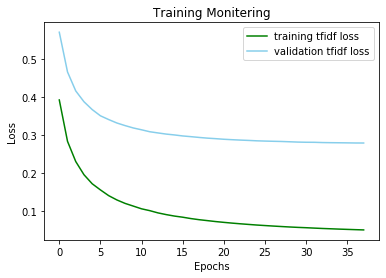

In [321]:
cur_size_tfidf_topic = loss_tr_tfidf.shape[0]
x_tfidf_topic = np.linspace(0,cur_size_tfidf_topic-1,num = cur_size_tfidf_topic)
plt.title('Training Monitering')
plt.plot(x_tfidf_topic, loss_tr_tfidf, color='green', label='training tfidf loss')
plt.plot(x_tfidf_topic, loss_dev_tfidf, color='skyblue', label='validation tfidf loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

It may be about right. Because both the validation loss and training loss tends to be stable, their losses are both relatively small and their losses doen't differ a lot.

In [298]:
print('Accuracy:', accuracy_score2(Y_topic_test,X_test_topic_tfidf))
print('Precision:', precision_score2(Y_topic_test,X_test_topic_tfidf))
print('Recall:', recall_score2(Y_topic_test,X_test_topic_tfidf))
print('F1-Score:', f1_score2(Y_topic_test,X_test_topic_tfidf))

Accuracy: 0.8733333333333333
Precision: 0.8747643595974796
Recall: 0.8733333333333334
F1-Score: 0.8740482607326477


In [299]:
w_count_tfidf = np.array(w_count_tfidf)

for i, ele in enumerate(w_count_tfidf):
    Z_w_topic = zip(ele,vocab_topic)
    Z_w_sorted_topic = sorted(Z_w_topic,key=lambda x: x[0],reverse=True)
    w_new_topic,vocab_new_topic = zip(*Z_w_sorted_topic)

    # so the top 10 words for the current class are below:
    top_topic_10 = vocab_new_topic[:10]
    print('top 10 words for the class %d:\n %s\n'%(i+1, top_topic_10))

top 10 words for the class 1:
 ('afp', ('athens', 'greece'), 'beijing', 'murder', 'said', 'najaf', 'leader', 'india', 'monday', 'president')

top 10 words for the class 2:
 ('ap', 'athens', 'team', ('athens', 'reuters'), 'olympic', 'season', 'game', 'baseball', 'players', 'coach')

top 10 words for the class 3:
 ('company', 'business', 'market', 'oil', 'inc', 'corp', 'google', 'based', 'bank', 'pay')



According to the top 10 words in the tfidf mode. These features can't generalise well for they are all specified terms.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

I choose the right value of learning rate and regularisation strength to make the train loss and validation loss prone to be right at the stable status and make the losses as small as possible or the F1-score as high as possible and prevent the overfitting phenomenon. When the learning rate is greater, the epochs are less. The regularisation strength can accelerate the training process but may make the final losses not reach to a stable status.

### Now evaluate BOW-tfidf...

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.869|0.868|0.868|
| BOW-tfidf  |0.875|0.873|0.874|
